Fold 1 - R²: 0.187, RMSE: 4.442, MAE: 3.697
Fold 2 - R²: 0.075, RMSE: 5.260, MAE: 4.185
Fold 3 - R²: 0.137, RMSE: 5.242, MAE: 3.915
Fold 4 - R²: 0.148, RMSE: 5.400, MAE: 4.217
Fold 5 - R²: 0.148, RMSE: 5.591, MAE: 4.400

average R²:   0.139 ± 0.018 (95% CI: [0.088, 0.189])
average RMSE: 5.187
average MAE:  4.083


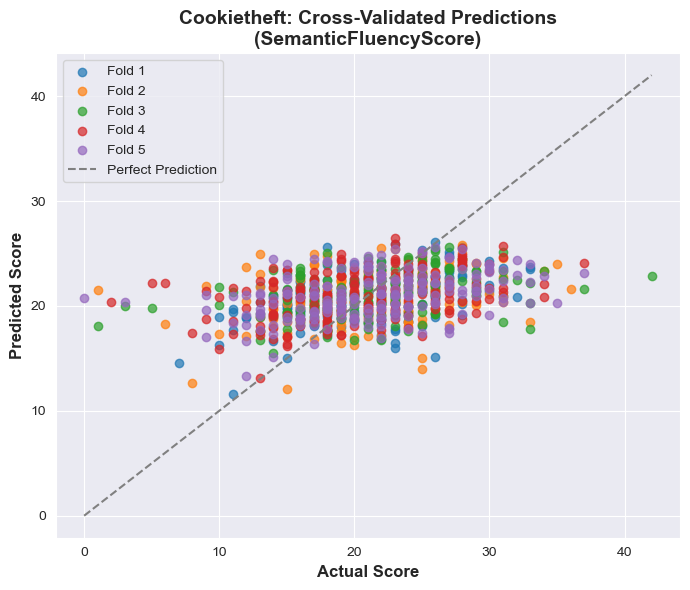

saved per-fold CV results to:
/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/cross_validation/cv_folds_cookieTheft_SemanticFluencyScore_RandomForestRegressor.csv
saved CV summary to:
/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/cross_validation/cv_summary_cookieTheft_SemanticFluencyScore_RandomForestRegressor.csv
CV prediction plot saved to: /Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/results/cross_validation/cv_prediction_plot_cookieTheft_SemanticFluencyScore_RandomForestRegressor.png


In [13]:
# setup
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from regression.regression_functions import cross_validate_model, save_crossval_results

# adjust task and target
task_name = "cookieTheft"
target = "SemanticFluencyScore"

# define the model
model_class = RandomForestRegressor
model_params = {"n_estimators": 100, "random_state": 42}

# paths
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
scores_path = os.path.join(GIT_DIRECTORY, "resources/language_scores_all_subjects.csv")

# load and merge data
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)

df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID").dropna()

X = df.drop(columns=["Subject_ID", target])
y = df[target]

# standardize X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# cross-validate using function
r2_list, rmse_list, mae_list, all_preds = cross_validate_model(
    X_scaled, y,
    model_class=model_class,
    model_params=model_params,
    n_splits=5
)

# summary stats
r2_mean = np.mean(r2_list)
r2_std = np.std(r2_list, ddof=1)
r2_se = r2_std / np.sqrt(len(r2_list))

t_score = stats.t.ppf(0.975, df=len(r2_list) - 1)
r2_ci_low = r2_mean - t_score * r2_se
r2_ci_high = r2_mean + t_score * r2_se

print(f"\naverage R²:   {r2_mean:.3f} ± {r2_se:.3f} (95% CI: [{r2_ci_low:.3f}, {r2_ci_high:.3f}])")
print(f"average RMSE: {np.mean(rmse_list):.3f}")
print(f"average MAE:  {np.mean(mae_list):.3f}")

# plot predictions
plt.figure(figsize=(7, 6))
for fold in all_preds['fold'].unique():
    fold_df = all_preds[all_preds['fold'] == fold]
    plt.scatter(fold_df["y_test"], fold_df["y_pred"], label=f"Fold {fold + 1}", alpha=0.7)

plt.plot(
    [all_preds["y_test"].min(), all_preds["y_test"].max()],
    [all_preds["y_test"].min(), all_preds["y_test"].max()],
    linestyle='--',
    color='gray',
    label="Perfect Prediction"
)

plt.xlabel("Actual Score", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Score", fontsize=12, fontweight="bold")
plt.title(f"{task_name.title()}: Cross-Validated Predictions\n({target})", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model_name = model_class.__name__

# save results
save_crossval_results(
    r2_list, rmse_list, mae_list,
    r2_mean, r2_std, r2_se, r2_ci_low, r2_ci_high,
    task_name, target,
    output_dir=os.path.join(GIT_DIRECTORY, "results", "cross_validation"),
    all_preds=all_preds,
    model_type=model_name
)
